In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mugan1","key":"1e7737f2708c99e5cec5976bb162f6fb"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d datasnaek/chess
!unzip chess.zip

In [ ]:
# Install

%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [ ]:
# import lib

import pandas as pd 
import numpy as np

# visualize 

import seaborn as sns
import matplotlib.pyplot as plt

# ML

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from category_encoders import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


# analysis

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from pandas_profiling import ProfileReport
import eli5
from eli5.sklearn import PermutationImportance
from scipy.stats import randint, uniform
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap
from yellowbrick.classifier import ROCAUC

# evaluate

from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_val_score

# ignoring warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# loading chess game 

chess= pd.read_csv('games.csv')
chess.head()

id  rated  ...                            opening_name  opening_ply
0  TZJHLljE  False  ...        Slav Defense: Exchange Variation            5
1  l1NXvwaE   True  ...  Nimzowitsch Defense: Kennedy Variation            4
2  mIICvQHh   True  ...   King's Pawn Game: Leonardis Variation            3
3  kWKvrqYL   True  ...  Queen's Pawn Game: Zukertort Variation            3
4  9tXo1AUZ   True  ...                        Philidor Defense            5

[5 rows x 16 columns]

In [ ]:
profile = ProfileReport(chess, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# ProfileReport EDA

- 20058 Row, 16 Column 의 데이터
- 중복행 429 Row 존재
- High Cardinality : id, increment_code, white_id, black_id, moves, opening_eco, opening_name -> 이 중 id 관련된 항목은 분석에 불필요한 데이터로 판단하므로 삭제
- 결측치 없음 
- Categorical Data 9개, Boolean Data 1개, Numerical Data 6개

# Data Description

- id : 게임 아이디 
- Rated : 게임 방식(Rating/Casual) - Casual 게임은 rating에 영향을 받지 않음
- created_at : 게임 시작시간
- last_move_at : 게임 종료시간
- turns : 게임 턴 수 
- victory_status : 승리 방식(체크메이트, 시간초과, 기권, 무승부)
- winner : 우승자 
- increment_code : 게임 시간 룰
- white_id : 백 아이디 
- white_rating : 백 rating 점수
- black_id : 흑 아이디 
- black_rating : 흑 rating 점수 
- moves : 기물의 이동 기록
- opening_eco : 오프닝 코드 넘버
- opening_name : 오프닝 이름 
- opening_ply : 오프닝 이동 횟수

# 분석목표 

- 체스게임의 승자가 누구인지(백/흑/무승부) 예측하기
- class는 [백,흑,무승부] 3개로 구분할 수 있으므로 다중클래스 분류

# 분류지표

- 무승부는 전체 데이터 중 950개 밖에 없으며, 백/흑의 클래스 비율은 균일한 편이므로 1차적 평가지표는 accuracy
- 정밀도, 재현율
- 따라서 2차적 평가지표는 ROC_AUC Score(재현율, 위양성률(fp/fp+tn) 반영) 

# 기준모델

- 클래스 범주의 비율로 기준모델을 정함

# 가설 

1. 백과 흑의 rating 점수의 차는 승자와 연관성이 있다
2. 기물의 이동 기록 중 'x'(기물을 잡은 기호)는 승자와 연관성이 있다
3. 기물의 이동 기록 중 '+'(메이트 기호)는 승자와 연관성이 있다
4. 오프닝의 스타일은 승자와 연관성이 있다
5. 게임 시간은 무승부와의 연관성이 있다
6. 게임 턴 수는 무승부와의 연관성이 있다


In [ ]:
# Data Wrangling

# rating gap
chess['rating_gap'] = chess.white_rating - chess.black_rating

# 경기시간(game_seconds) 컬럼 추가 -> ms를 초로 변환

chess['game_seconds'] = (chess.last_move_at-chess.created_at)/1000

# increment_code Clustering

speed_list = []

def clustering(string) :
  minute = int(string.split('+')[0])
  if minute < 3 :
    speed_list = 'bullet'
  elif 3 <= minute & minute <8 :
    speed_list = 'blitz'
  elif 8 <= minute & minute <=20 :
    speed_list = 'rapid'
  else :
    speed_list = 'classic'
  return speed_list

chess['game_speed'] = chess.increment_code.apply(clustering)

# move(기물 이동 기록)에 따른 오프닝 클러스러팅

def move_openings(listed) : 

  if len(listed) >= 2 :
    if (listed[0] == 'e4') & (listed[1] == 'e5') :
      return "open_game"
    elif (listed[0] == 'e4') & (listed[1] != 'e5') :
      return "semi_open_game"
    elif (listed[0] == 'd4') & (listed[1] == 'd5') :
       return "closed_game"
    elif (listed[0] == 'd4') & (listed[1] != 'd5') :
       return "semi_closed_game"
    else : 
      return "flank_opening"
  else :
    if (listed[0] == 'e4') :
      return "open_game"
    elif (listed[0] == 'd4') :
      return "closed_game"
    else : 
      return "flank_opening"

chess['opening_class'] = chess.moves.str.split(" ").apply(move_openings)

# 이동 기록 중 'x'(기물을 잡은 기호) 횟수를 white_kill, black_kill 컬럼에 추가 
white_move = chess.moves.str.split(" ").apply(lambda x : x[::2])
black_move = chess.moves.str.split(" ").apply(lambda x : x[1::2])

def kills(string):
    string = pd.Series(string)
    return string.apply((lambda x : 1 if "x" in x else 0)).sum()

chess['white_kill'] = white_move.apply(kills).astype(int)
chess['black_kill'] = black_move.apply(kills).astype(int)

# 이동 기록 중 '+'(메이트 기호) 횟수를 white_mate, black_mate 컬럼에 추가 
def mate(string):
    string = pd.Series(string)
    return string.apply((lambda x : 1 if "+" in x else 0)).sum()

chess['white_mate'] = white_move.apply(mate).astype(int)
chess['black_mate'] = black_move.apply(mate).astype(int)

# opening name(오프닝 이름)에 따른 오프닝 클러스터링  
def group_opening(string) :
  if ('Gambit' in string) & ('Attack' not in string) & ('Defense' not in string):
    return 'gambit'
  elif ('Gambit' not in string) & ('Attack' in string) & ('Defense' not in string):
    return 'attack'
  elif ('Gambit' not in string) & ('Attack' not in string) & ('Defense' in string):
    return 'defense'
  elif ('Gambit' not in string) & ('Attack' not in string) & ('Defense' not in string) & ('Opening' in string) :
    return 'opening'
  elif ('Gambit' not in string) & ('Attack' not in string) & ('Defense' not in string) & ('Opening' not in string) & (('Game' in string)) :
    return 'game'
  else : 
    return 'combination'

chess['opening_style'] = chess.opening_name.apply(group_opening)

In [ ]:
# # Numerical Data Visualize

# features_num = ['created_at', 'last_move_at', 'turns', 'white_rating', 'black_rating','opening_ply', 'rating_gap', 'game_seconds', 'white_kill', 'black_kill', 'white_mate', 'black_mate']

# for f in features_num:
#     sns.displot(chess[f], kde=True, height=4, aspect = 1);

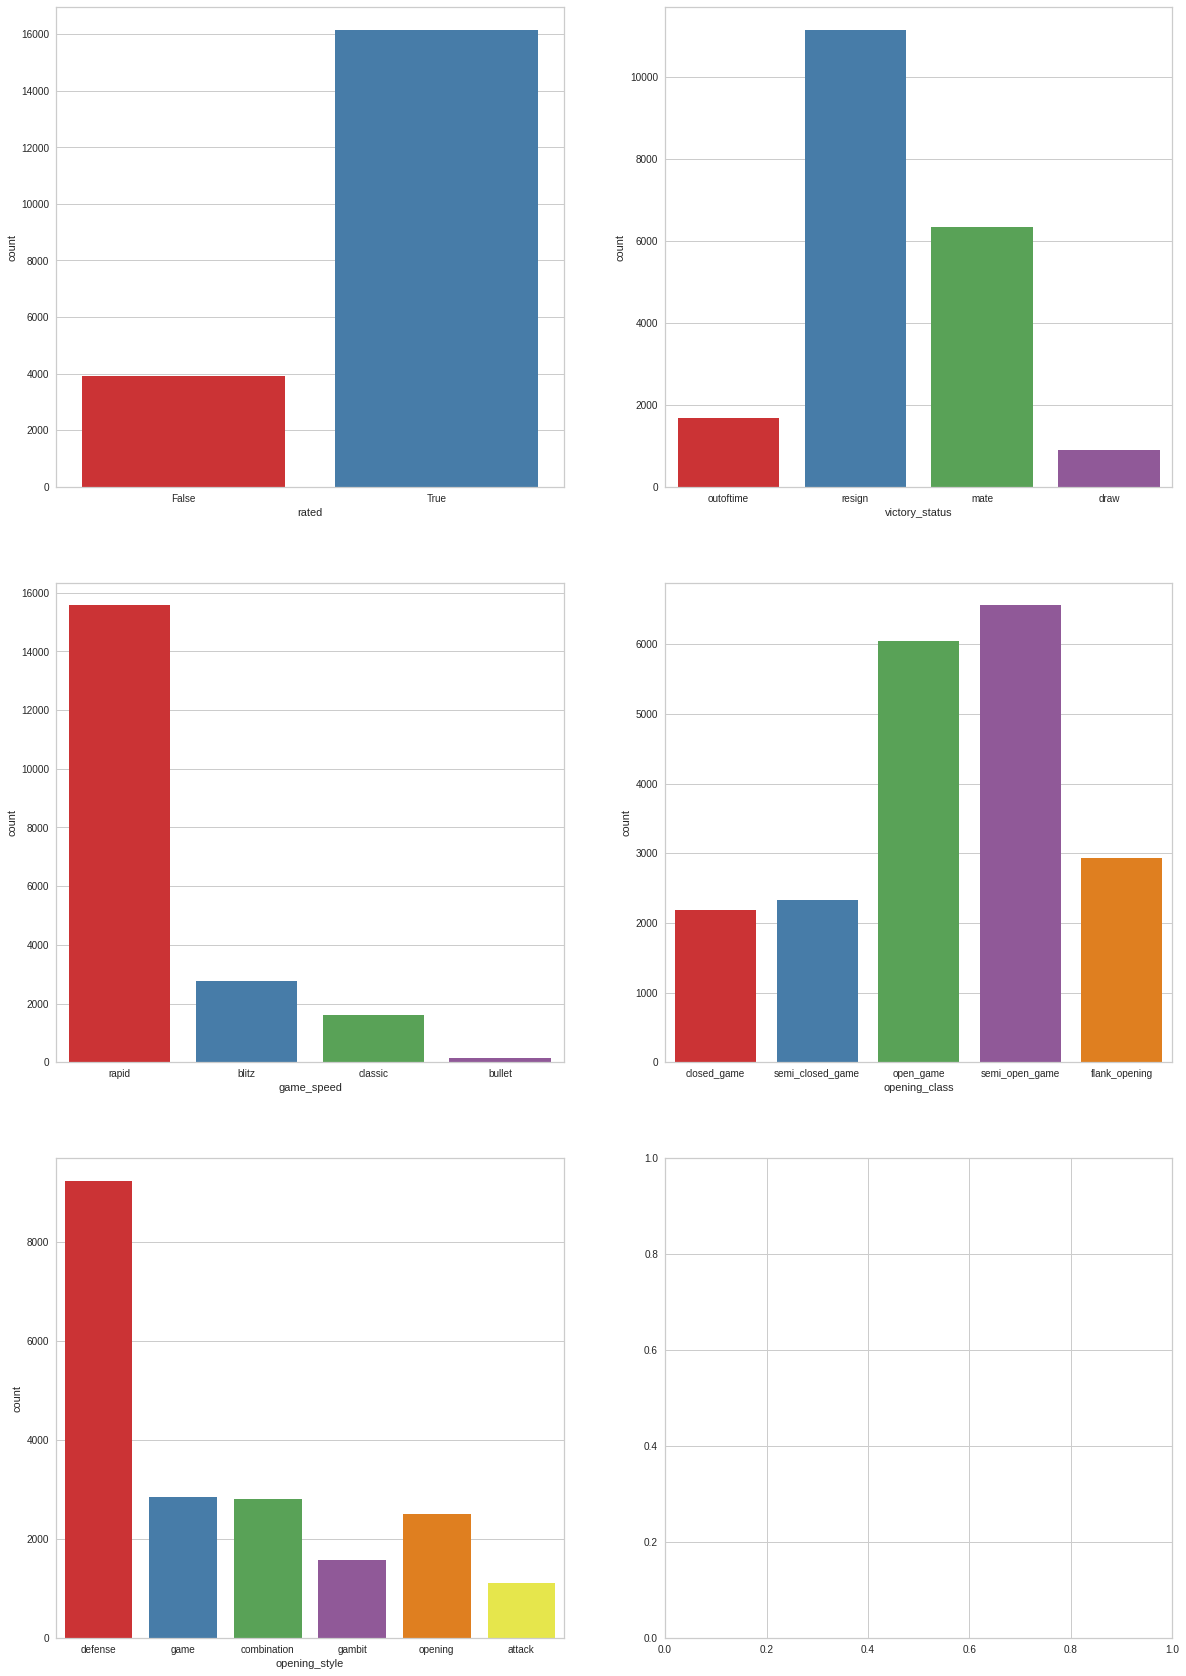

In [ ]:
# # Categorlcal Data 분포 시각화

# features_cat = ['rated', 'victory_status', 'game_speed', 'opening_class', 'opening_style']
# fig, ax = plt.subplots(3,2, figsize=(20,30))

# index=0
# for ax in ax:
#     for a in ax: 
#       if len(features_cat) > index :
#         sns.countplot(x= features_cat[index], ax=a, data=chess, palette='Set1')
#         index += 1

# plt.show();

In [ ]:
# Data Preprocessing

# drop_duplicates
chess.drop_duplicates(keep='first', inplace=True)

# delete features related in id 

dels = [cols for cols in chess.columns if 'id' in cols]
chess.drop(columns=dels, inplace=True)

# 경기시간 시각화 : 경기 시간이 비정상적으로 긴 시간은 이상치로 간주하여 제거하겠음

chess = chess[chess.game_seconds < 20000]

# 시작시간, 종료 시간 datatime 타입 변환

chess.created_at = pd.to_datetime(chess.created_at, unit='ms')  
chess.last_move_at = pd.to_datetime(chess.last_move_at, unit='ms')

# 게임 시간이 0인 경우를 게임 시간의 평균값으로 바꾸기

chess.game_seconds = chess.game_seconds.apply(lambda x : chess.game_seconds.mean() if x == 0 else x)

chess.drop(columns=['created_at','last_move_at' , 'increment_code', 'moves', 'opening_eco', 'opening_name'], inplace=True)

AttributeError: ignored

In [ ]:
# after preprocessing
def to_int(string) :
  if string == 'white' :
    string = 2
  elif string == 'black' :
    string = 0
  else : 
    string = 1
  return string

chess['winner_int'] = chess.winner.apply(to_int)
chess.head()

rated  turns victory_status  ... black_mate  opening_style  winner_int
0  False     13      outoftime  ...          1        defense           2
1   True     16         resign  ...          1        defense           0
2   True     61           mate  ...          0           game           2
3   True     61           mate  ...          0           game           2
4   True     95           mate  ...          4        defense           2

[5 rows x 17 columns]

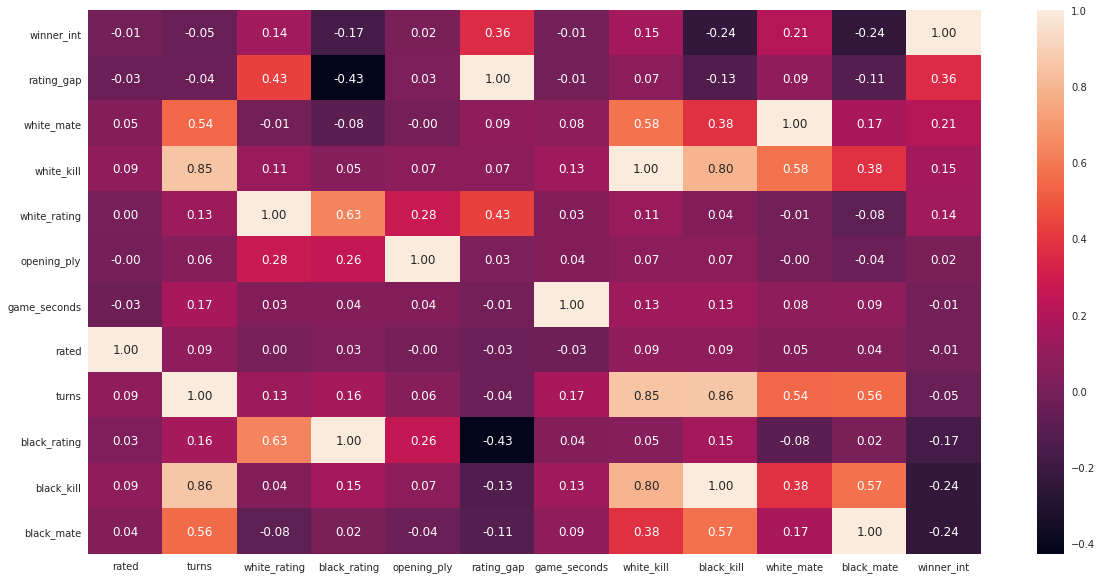

In [ ]:
# Numerical Data와 Target 상관관계 시각화
chess_co = chess.corr().sort_values(by='winner_int', ascending=False)
fig,ax = plt.subplots(figsize=(20,10))
sns.heatmap(chess_co, annot=True, fmt='.2f')
plt.show();

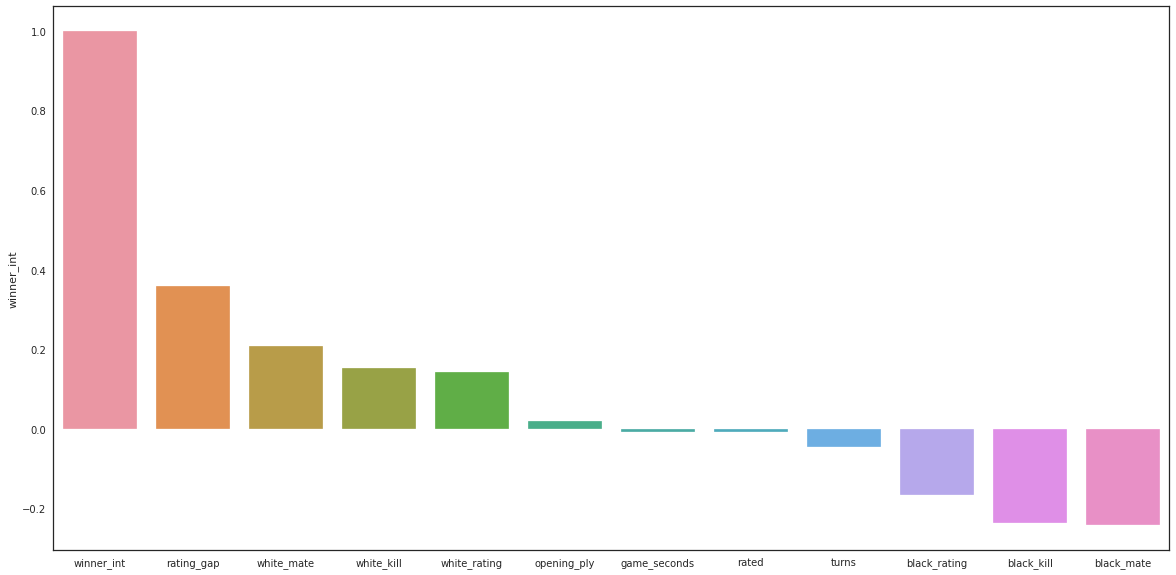

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
sns.barplot(x=chess_co.index, y=chess_co.winner_int);

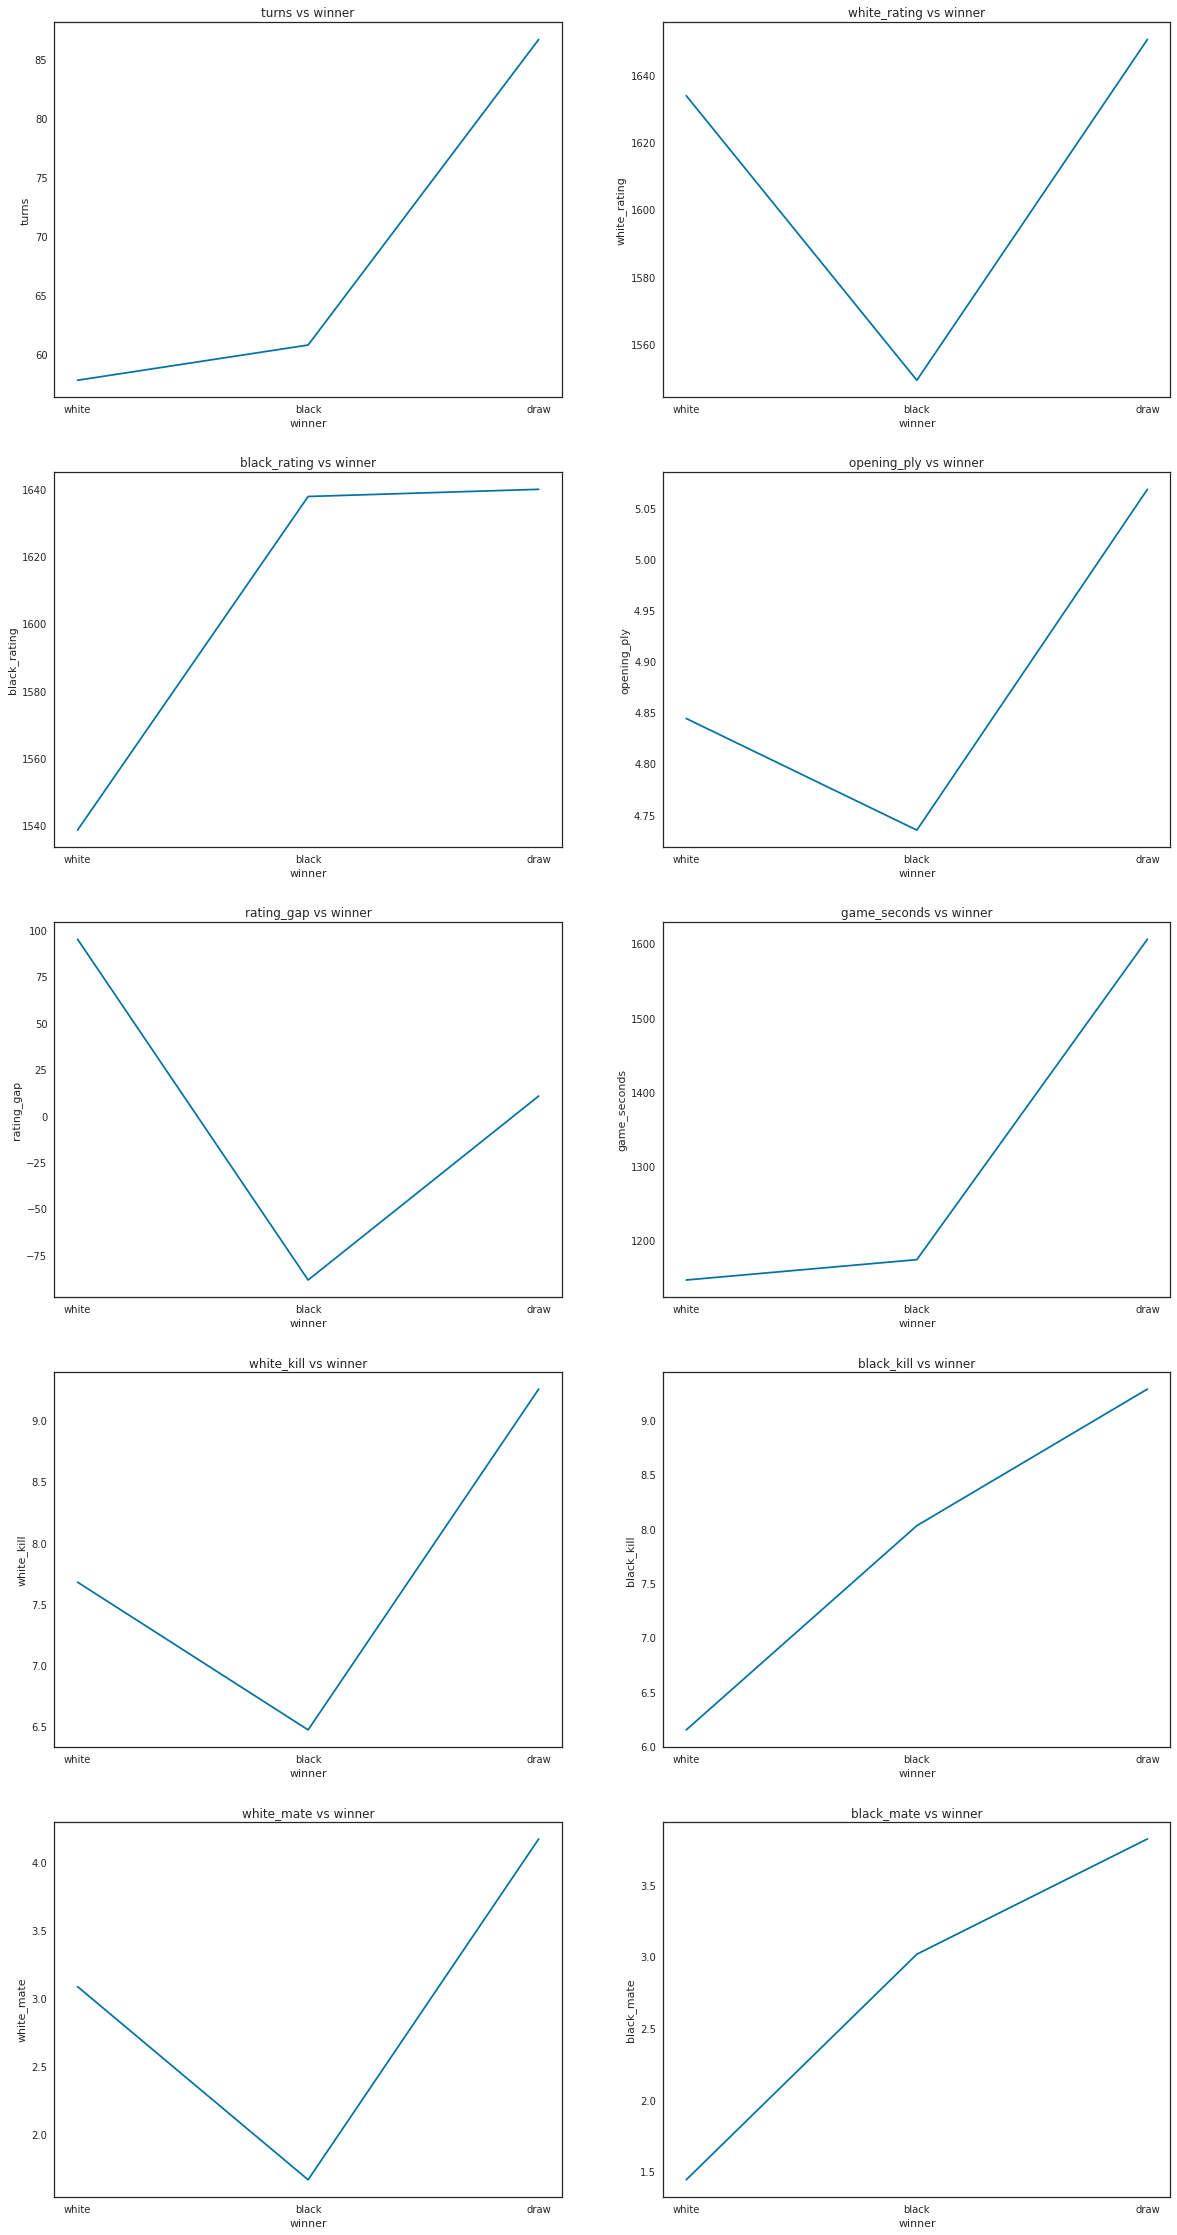

In [ ]:
# Winner와 Numerical Data 상관관계 시각화 
features_num = ['turns', 'white_rating', 'black_rating','opening_ply', 'rating_gap', 'game_seconds', 'white_kill', 'black_kill', 'white_mate', 'black_mate']
fig,ax = plt.subplots(5,2,figsize=(20,40))
sns.set_style("white")
index=0
for ax in ax:
    for a in ax:
        if len(features_num)>index:
          sns.lineplot(x='winner',y=features_num[index],data=chess, ax=a, ci=None)
          a.set_title('{} vs winner'.format(features_num[index]))
          index +=1
plt.show();

In [ ]:
# chi2 test

for f in features_num :

  chess_crossed = pd.crosstab(chess.winner, chess[f])

  fvalue, pvalue,_,_ = chi2_contingency(chess_crossed, correction = True)
  
  if pvalue < 0.05 :
    print(f'pvalue가 0.05보다 작으므로 승자와 {f}간에는 연관이 있다')
  else : 
    print(f'pvalue가 0.05보다 크므로 승자와 {f}간에는 연관이 없다')

pvalue가 0.05보다 작으므로 승자와 turns간에는 연관이 있다
pvalue가 0.05보다 작으므로 승자와 white_rating간에는 연관이 있다
pvalue가 0.05보다 작으므로 승자와 black_rating간에는 연관이 있다
pvalue가 0.05보다 작으므로 승자와 opening_ply간에는 연관이 있다
pvalue가 0.05보다 작으므로 승자와 rating_gap간에는 연관이 있다
pvalue가 0.05보다 작으므로 승자와 game_seconds간에는 연관이 있다
pvalue가 0.05보다 작으므로 승자와 white_kill간에는 연관이 있다
pvalue가 0.05보다 작으므로 승자와 black_kill간에는 연관이 있다
pvalue가 0.05보다 작으므로 승자와 white_mate간에는 연관이 있다
pvalue가 0.05보다 작으므로 승자와 black_mate간에는 연관이 있다


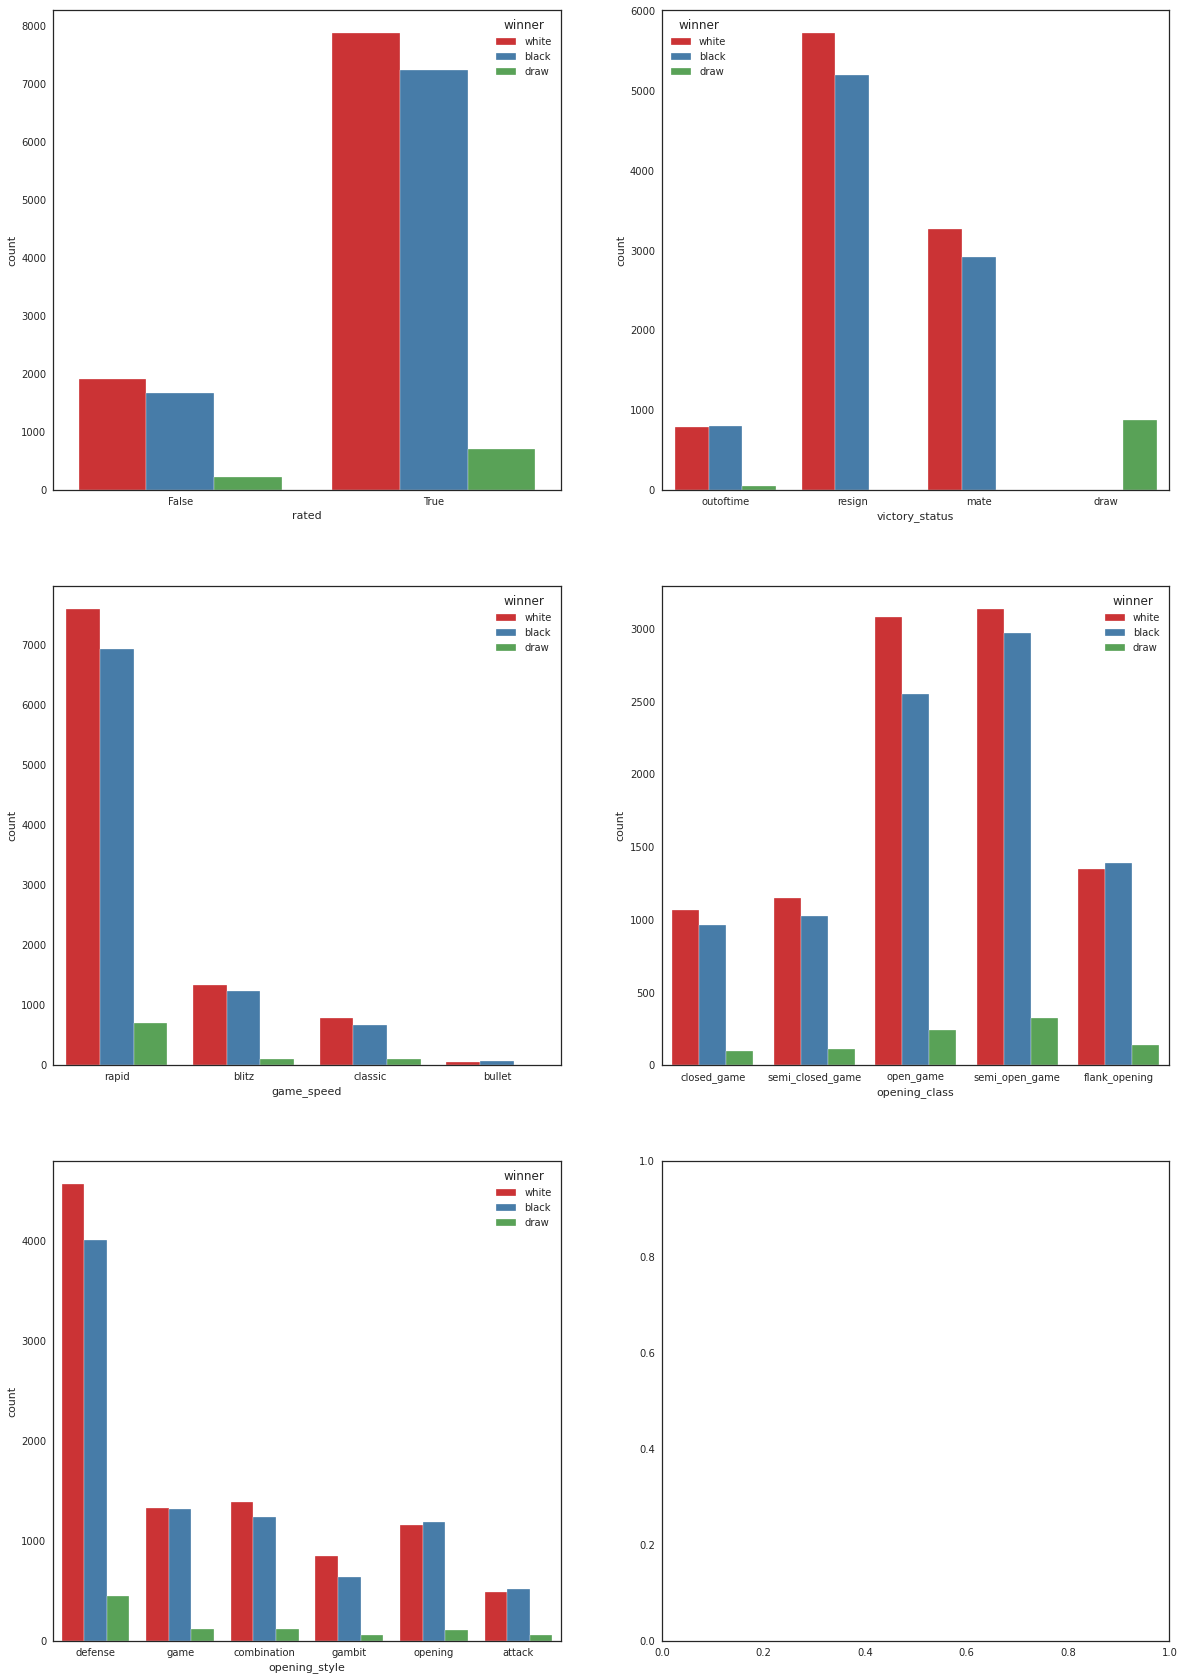

In [ ]:
# Categorlcal Data와 Target 상관관계 시각화

features_cat = ['rated', 'victory_status', 'game_speed', 'opening_class', 'opening_style']
fig, ax = plt.subplots(3,2, figsize=(20,30))

index=0
for ax in ax:
    for a in ax: 
      if len(features_cat) > index :
        sns.countplot(x= features_cat[index], hue='winner', ax=a, data=chess, palette='Set1')
        index += 1

plt.show();

In [ ]:
features_cat_all = ['rated', 'victory_status', 'game_speed', 'opening_class', 'opening_style']

for c in features_cat_all :

  chess_crossed = pd.crosstab(chess.winner, chess[c])

  fvalue, pvalue,_,_ = chi2_contingency(chess_crossed, correction = True)
  if pvalue < 0.05 :
    print(f'pvalue가 0.05보다 작으므로 승자와 {c}간에는 연관이 있다')
  else : 
    print(f'pvalue가 0.05보다 크므로 승자와 {c}간에는 연관이 없다')

pvalue가 0.05보다 작으므로 승자와 rated간에는 연관이 있다
pvalue가 0.05보다 작으므로 승자와 victory_status간에는 연관이 있다
pvalue가 0.05보다 작으므로 승자와 game_speed간에는 연관이 있다
pvalue가 0.05보다 작으므로 승자와 opening_class간에는 연관이 있다
pvalue가 0.05보다 작으므로 승자와 opening_style간에는 연관이 있다


# Modeling 

In [ ]:
# 6:2:2 비율로 훈련/검증/테스트 데이터 나누기 

target = 'winner'
X = chess.drop(columns=[target,'winner_int', 'victory_status'])
y = chess[target]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y , train_size=0.80, test_size=0.20, stratify=y, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.80, test_size=0.20, stratify=y_train_val, random_state=1)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (12556, 14)
y_train shape (12556,)
X_val shape (3140, 14)
y_val shape (3140,)
X_test shape (3925, 14)
y_test shape (3925,)


In [ ]:
# Base Model 
y_train.value_counts(normalize=True)

white    0.498965
black    0.454364
draw     0.046671
Name: winner, dtype: float64

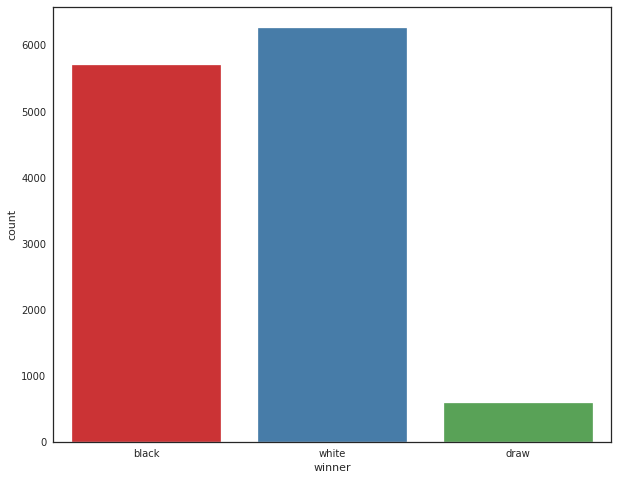

In [ ]:
fig,ax=plt.subplots(figsize=(10,8))
sns.set_style('white')
sns.countplot(y_train, palette='Set1');

In [ ]:
# # Early Stopping with victory_status

# pipe_xgb_e = Pipeline([
#     ('preprocessing', make_pipeline(OrdinalEncoder())),
#     ('xgb', XGBClassifier(n_estimators=1000, max_depth=7, learning_rate = 0.2, n_jobs=-1, random_state=1)) 
# ])

# X_train_processed = pipe_xgb_e.named_steps['preprocessing'].fit_transform(X_train)
# X_val_processed = pipe_xgb_e.named_steps['preprocessing'].transform(X_val)

# eval_set = [(X_train_processed, y_train), 
#             (X_val_processed, y_val)]

# model = pipe_xgb_e.named_steps['xgb']
# model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='merror', 
#           early_stopping_rounds=50)

In [ ]:
# print('검증 정확도', model.score(X_val_processed, y_val))

# X_test_processed = pipe_xgb_e.named_steps['preprocessing'].transform(X_test)

# print('테스트 정확도', model.score(X_test_processed, y_test)
# )
# pred_xgb_e = model.predict(X_val_processed)

# pred_proba_xgb_e = model.predict_proba(X_val_processed)

# print(classification_report(y_val, pred_xgb_e))

In [ ]:
# target = 'winner'
# X = chess.drop(columns=[target,'winner_int', 'victory_status'])
# y = chess[target]

# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y , train_size=0.80, test_size=0.20, stratify=y, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.80, test_size=0.20, stratify=y_train_val, random_state=1)

# print('X_train shape', X_train.shape)
# print('y_train shape', y_train.shape)
# print('X_val shape', X_val.shape)
# print('y_val shape', y_val.shape)
# print('X_test shape', X_test.shape)
# print('y_test shape', y_test.shape)

In [ ]:
# # Early Stopping without victory_status

# pipe_xgb_e = Pipeline([
#     ('preprocessing', make_pipeline(OrdinalEncoder())),
#     ('xgb', XGBClassifier(n_estimators=1000, max_depth=7, learning_rate = 0.2, n_jobs=-1, random_state=1)) 
# ])

# X_train_processed = pipe_xgb_e.named_steps['preprocessing'].fit_transform(X_train)
# X_val_processed = pipe_xgb_e.named_steps['preprocessing'].transform(X_val)

# eval_set = [(X_train_processed, y_train), 
#             (X_val_processed, y_val)]

# model = pipe_xgb_e.named_steps['xgb']
# model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='merror', 
#           early_stopping_rounds=50)

In [ ]:
# print('검증 정확도', model.score(X_val_processed, y_val))

# X_test_processed = pipe_xgb_e.named_steps['preprocessing'].transform(X_test)

# print('테스트 정확도', model.score(X_test_processed, y_test)
# )
# pred_xgb_e = model.predict(X_val_processed)

# pred_proba_xgb_e = model.predict_proba(X_val_processed)

# print(classification_report(y_val, pred_xgb_e))

In [ ]:
# OneVSRest Logistic Regression 

pipe_log = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), StandardScaler())),
    ('lr', LogisticRegression(random_state=1, multi_class='ovr')) 
])
pipe_log.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=['game_speed',
                                                       'opening_class',
                                                       'opening_style'],
                                                 drop_invariant=False,
                                                 handle_missing='value',
                                                 handle_unknown='value',
                                                 mapping=[{'col': 'game_speed',
                                                           'data_type': dtype('O'),
                                                           'mapping': rapid      1
blitz      2
classic    3
bullet     4
NaN       -2
dtype: int64},
                                                          {'col': 'opening_cl...
                           

In [ ]:
print('검증 정확도', pipe_log.score(X_val, y_val))
pred_lr = pipe_log.predict(X_val)
print(classification_report(pred_lr, y_val))

pred_proba_lr = pipe_log.predict_proba(X_val)
print('ROC Score', roc_auc_score(y_val, pred_proba_lr, multi_class='ovr'))

검증 정확도 0.7904458598726115
              precision    recall  f1-score   support

       black       0.82      0.78      0.80      1506
        draw       0.01      0.50      0.01         2
       white       0.84      0.80      0.82      1632

    accuracy                           0.79      3140
   macro avg       0.55      0.69      0.54      3140
weighted avg       0.83      0.79      0.81      3140

ROC Score 0.818107216979666


In [ ]:
# Decision Tree with RandomizedSearchCV

pipe_dt = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder())),
    ('dt', DecisionTreeClassifier(random_state=1)) 
])

dists = {   
    'dt__max_depth': randint(5,20), 
    'dt__min_samples_leaf' : randint(1,5),
    'dt__min_samples_split' : randint(2,20)
}
clf_dt = RandomizedSearchCV(
    pipe_dt, 
    param_distributions=dists, 
    n_iter=30, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

clf_dt.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.6s finished


In [ ]:
print('최적 하이퍼파라미터: ', clf_dt.best_params_)
print('accuracy: ', clf_dt.best_score_)

# pipe에 best_estimator를 적용함

pipe_dt = clf_dt.best_estimator_
print('검증 정확도', pipe_dt.score(X_val, y_val))
pred_dt = pipe_dt.predict(X_val)
print(classification_report(pred_dt, y_val))

pred_proba_dt = pipe_dt.predict_proba(X_val)
print('ROC Score', roc_auc_score(y_val, pred_proba_dt, multi_class='ovr'))

최적 하이퍼파라미터:  {'dt__max_depth': 8, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 10}
accuracy:  0.7413989435494811
검증 정확도 0.7471337579617834
              precision    recall  f1-score   support

       black       0.73      0.75      0.74      1392
        draw       0.18      0.45      0.26        60
       white       0.81      0.75      0.78      1688

    accuracy                           0.75      3140
   macro avg       0.58      0.65      0.60      3140
weighted avg       0.77      0.75      0.75      3140

ROC Score 0.7982463319906827


In [ ]:
# RandomForest with RandomizedSearchCV

pipe_rf = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder())),
    ('rf', RandomForestClassifier(random_state=1)) 
])

dists = {   
    'rf__n_estimators' : randint(100, 300), 
    'rf__max_depth': randint(5,20), 
    'rf__min_samples_leaf' : randint(1,5),
    'rf__min_samples_split' : randint(2,20)
}
clf_rf = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=dists, 
    n_iter=30, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

clf_rf.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.1min finished


In [ ]:
print('최적 하이퍼파라미터: ', clf_rf.best_params_)
print('accuracy: ', clf_rf.best_score_)

최적 하이퍼파라미터:  {'rf__max_depth': 17, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 291}
accuracy:  0.7849640654222235


In [ ]:
pd.DataFrame(clf_rf.cv_results_).sort_values(by='rank_test_score').T

12  ...                                                 1 
mean_fit_time                                                          4.74921  ...                                             2.0316
std_fit_time                                                         0.0712778  ...                                         0.00846993
mean_score_time                                                       0.290227  ...                                           0.144884
std_score_time                                                       0.0010701  ...                                         0.00250151
param_rf__max_depth                                                         17  ...                                                  6
param_rf__min_samples_leaf                                                   1  ...                                                  1
param_rf__min_samples_split                                                  5  ...                                                  4
param_rf__n_estimators                                                     291  ...                                                213
params                       {'rf__max_depth': 17, 'rf__min_samples_leaf': ...  ...  {'rf__max_depth': 6, 'rf__min_samples_leaf': 1...
split0_test_score                                                     0.776159  ...                                           0.731247
split1_test_score                                                      0.79307  ...                                           0.755795
split2_test_score                                                     0.785663  ...                                           0.744325
mean_test_score                                                       0.784964  ...                                           0.743789
std_test_score                                                      0.00692191  ...                                          0.0100286
rank_test_score                                                              1  ...                                                 30

[15 rows x 30 columns]

In [ ]:
# pipe에 best_estimator를 적용함

pipe_rf = clf_rf.best_estimator_

print('검증 정확도', pipe_rf.score(X_val, y_val))
pred_rf = pipe_rf.predict(X_val)
print(classification_report(pred_rf, y_val))

pred_proba_rf = pipe_rf.predict_proba(X_val)
print('ROC Score', roc_auc_score(y_val, pred_proba_rf, multi_class='ovr'))

검증 정확도 0.7853503184713376
              precision    recall  f1-score   support

       black       0.80      0.77      0.79      1486
        draw       0.18      1.00      0.30        26
       white       0.83      0.80      0.81      1628

    accuracy                           0.79      3140
   macro avg       0.60      0.86      0.63      3140
weighted avg       0.81      0.79      0.79      3140

ROC Score 0.8627473971337839


In [ ]:
# XGB boost with with RandomizedSearchCV

pipe_xgb = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder())),
    ('xgb', XGBClassifier(random_state=1))])

dists = {   
    'xgb__n_estimators' : randint(200, 300),
    'xgb__learning_rate' : uniform(0, 1),
    'xgb__max_depth': [3,4,5,6,7,8,9,10], 
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
}
clf_xgb = RandomizedSearchCV(
    pipe_xgb, 
    param_distributions=dists, 
    n_iter=20, 
    cv=3, 
    scoring='accuracy', 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=1
)

clf_xgb.fit(X_train, y_train);

In [ ]:
print('최적 하이퍼파라미터: ', clf_xgb.best_params_)
print('accuracy: ', clf_xgb.best_score_)

최적 하이퍼파라미터:  {'xgb__gamma': 0.5, 'xgb__learning_rate': 0.8946066635038473, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 213, 'xgb__subsample': 1.0}
accuracy:  0.8395988943441024


In [ ]:
pd.DataFrame(clf_xgb.cv_results_).sort_values(by='rank_test_score').T

6  ...                                                  2
mean_fit_time                                                          3.71213  ...                                            15.5211
std_fit_time                                                         0.0573886  ...                                           0.373699
mean_score_time                                                      0.0835668  ...                                           0.194765
std_score_time                                                      0.00486196  ...                                         0.00411693
param_xgb__gamma                                                           0.5  ...                                                1.5
param_xgb__learning_rate                                              0.894607  ...                                           0.846311
param_xgb__max_depth                                                         3  ...                                                  8
param_xgb__min_child_weight                                                  1  ...                                                 10
param_xgb__n_estimators                                                    213  ...                                                284
param_xgb__subsample                                                         1  ...                                                0.6
params                       {'xgb__gamma': 0.5, 'xgb__learning_rate': 0.89...  ...  {'xgb__gamma': 1.5, 'xgb__learning_rate': 0.84...
split0_test_score                                                     0.835882  ...                                           0.805065
split1_test_score                                                     0.838949  ...                                           0.808363
split2_test_score                                                     0.843967  ...                                           0.801912
mean_test_score                                                       0.839599  ...                                           0.805113
std_test_score                                                      0.00333258  ...                                         0.00263408
rank_test_score                                                              1  ...                                                 20
split0_train_score                                                    0.947073  ...                                           0.980884
split1_train_score                                                    0.924979  ...                                           0.979811
split2_train_score                                                    0.930594  ...                                           0.979931
mean_train_score                                                      0.934215  ...                                           0.980209
std_train_score                                                     0.00937622  ...                                        0.000480076

[22 rows x 20 columns]

In [ ]:
pipe_xgb = clf_xgb.best_estimator_

In [ ]:
print('검증 정확도', pipe_xgb.score(X_val, y_val))
pred_xgb = pipe_xgb.predict(X_val)
print(classification_report(pred_xgb, y_val))

검증 정확도 0.8538216560509554
              precision    recall  f1-score   support

       black       0.89      0.85      0.87      1496
        draw       0.24      0.58      0.34        60
       white       0.88      0.87      0.88      1584

    accuracy                           0.85      3140
   macro avg       0.67      0.77      0.69      3140
weighted avg       0.87      0.85      0.86      3140



In [ ]:
# Early Stopping 

pipe_xgb_e = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder())),
    ('xgb', XGBClassifier(n_estimators=1000, n_jobs=-1, max_depth=3, gamma=0.5, subsample = 1.0, learning_rate = 0.8946066635038473, random_state=1)) 
])

X_train_processed = pipe_xgb_e.named_steps['preprocessing'].fit_transform(X_train)
X_val_processed = pipe_xgb_e.named_steps['preprocessing'].transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = pipe_xgb_e.named_steps['xgb']
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='merror', 
          early_stopping_rounds=50)

[0]	validation_0-merror:0.303361	validation_1-merror:0.32293
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.271822	validation_1-merror:0.277389
[2]	validation_0-merror:0.250558	validation_1-merror:0.25414
[3]	validation_0-merror:0.22555	validation_1-merror:0.231847
[4]	validation_0-merror:0.224196	validation_1-merror:0.227389
[5]	validation_0-merror:0.21432	validation_1-merror:0.221019
[6]	validation_0-merror:0.208347	validation_1-merror:0.217197
[7]	validation_0-merror:0.206276	validation_1-merror:0.215287
[8]	validation_0-merror:0.205718	validation_1-merror:0.214968
[9]	validation_0-merror:0.202772	validation_1-merror:0.213057
[10]	validation_0-merror:0.200064	validation_1-merror:0.209554
[11]	validation_0-merror:0.19863	validation_1-merror:0.209873
[12]	validation_0-merror:0.197515	validation_1-merror:0.208599
[13]	validation_0-merror:0.197834

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5,
              learning_rate=0.8946066635038473, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1.0, verbosity=1)

In [ ]:
print('검증 정확도', model.score(X_val_processed, y_val))
pred_xgb_e = model.predict(X_val_processed)
print(classification_report(y_val, pred_xgb_e))

pred_proba_xgb_e = model.predict_proba(X_val_processed)
print('ROC Score', roc_auc_score(y_val, pred_proba_xgb_e, multi_class='ovr'))

검증 정확도 0.8550955414012739
              precision    recall  f1-score   support

       black       0.85      0.89      0.87      1426
        draw       0.64      0.24      0.35       147
       white       0.87      0.88      0.88      1567

    accuracy                           0.86      3140
   macro avg       0.78      0.67      0.70      3140
weighted avg       0.85      0.86      0.85      3140

ROC Score 0.9018338217079078


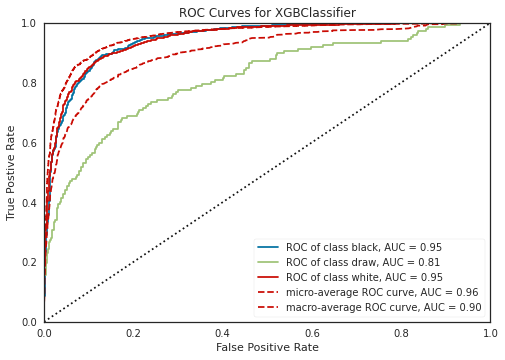

In [ ]:
# ROC Score

visualizer = ROCAUC(model, classes=["black", "draw", "white"])
visualizer.fit(X_train_processed, y_train)
visualizer.score(X_val_processed, y_val)  
r = visualizer.poof() 

In [ ]:
# CV

X = chess.drop(columns=[target, 'winner_int', 'victory_status'])
y = chess[target]
X_train, X_test, y_train, y_test = train_test_split(X, y , train_size=0.80, test_size=0.20, stratify=y, random_state=1)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (15696, 14)
y_train shape (15696,)
X_test shape (3925, 14)
y_test shape (3925,)


In [ ]:
X_train_processed = pipe_xgb_e.named_steps['preprocessing'].fit_transform(X_train)

scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='accuracy')

print(f'MAE for 5 folds:', scores)
print('평균 :', scores.mean())
print('표준편차 :', scores.std())

MAE for 5 folds: [0.84968153 0.85823511 0.8489965  0.86269513 0.84995221]
평균 : 0.853912094200149
표준편차 : 0.0055420488257228815


In [ ]:
# target = 'winner'
# X = chess.drop(columns=[target,'winner_int', 'victory_status'])
# y = chess[target]

# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y , train_size=0.80, test_size=0.20, stratify=y, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.80, test_size=0.20, stratify=y_train_val, random_state=1)

# print('X_train shape', X_train.shape)
# print('y_train shape', y_train.shape)
# print('X_val shape', X_val.shape)
# print('y_val shape', y_val.shape)
# print('X_test shape', X_test.shape)
# print('y_test shape', y_test.shape)

X_train shape (12556, 14)
y_train shape (12556,)
X_val shape (3140, 14)
y_val shape (3140,)
X_test shape (3925, 14)
y_test shape (3925,)


In [ ]:
X_test_processed = pipe_xgb_e.named_steps['preprocessing'].transform(X_test)
pred_xgb_e = model.predict(X_test_processed)
print('테스트 정확도', model.score(X_test_processed, y_test))
print(classification_report(y_test, pred_xgb_e))

pred_proba_xgb_e = model.predict_proba(X_test_processed)
print('ROC Score', roc_auc_score(y_test, pred_proba_xgb_e, multi_class='ovr'))

테스트 정확도 0.8420382165605096
              precision    recall  f1-score   support

       black       0.84      0.87      0.86      1783
        draw       0.47      0.15      0.23       184
       white       0.85      0.88      0.86      1958

    accuracy                           0.84      3925
   macro avg       0.72      0.63      0.65      3925
weighted avg       0.83      0.84      0.83      3925

ROC Score 0.8891880987267621


In [ ]:
# permutation

permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=5, 
    random_state=1
)

permuter.fit(X_test_processed, y_test);

In [ ]:
feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

game_speed      -0.001325
rated           -0.000204
opening_ply      0.001529
opening_style    0.002191
opening_class    0.003261
game_seconds     0.003363
black_rating     0.003822
white_rating     0.004331
white_mate       0.014675
black_mate       0.016000
rating_gap       0.017325
turns            0.098191
white_kill       0.187363
black_kill       0.219975
dtype: float64

In [ ]:
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names
) 

In [ ]:
# pdp plot

X_test_processed_df = pd.DataFrame(X_test_processed, columns=X_test.columns)
X_test_processed_df.head()

rated  turns  white_rating  ...  white_mate  black_mate  opening_style
3547    True    112          1679  ...           4           7              1
11318   True     99          1772  ...           3           3              4
9085   False     13          1110  ...           0           0              3
7053    True     59          1730  ...           0           0              3
18995   True    124          2229  ...           1           5              3

[5 rows x 14 columns]

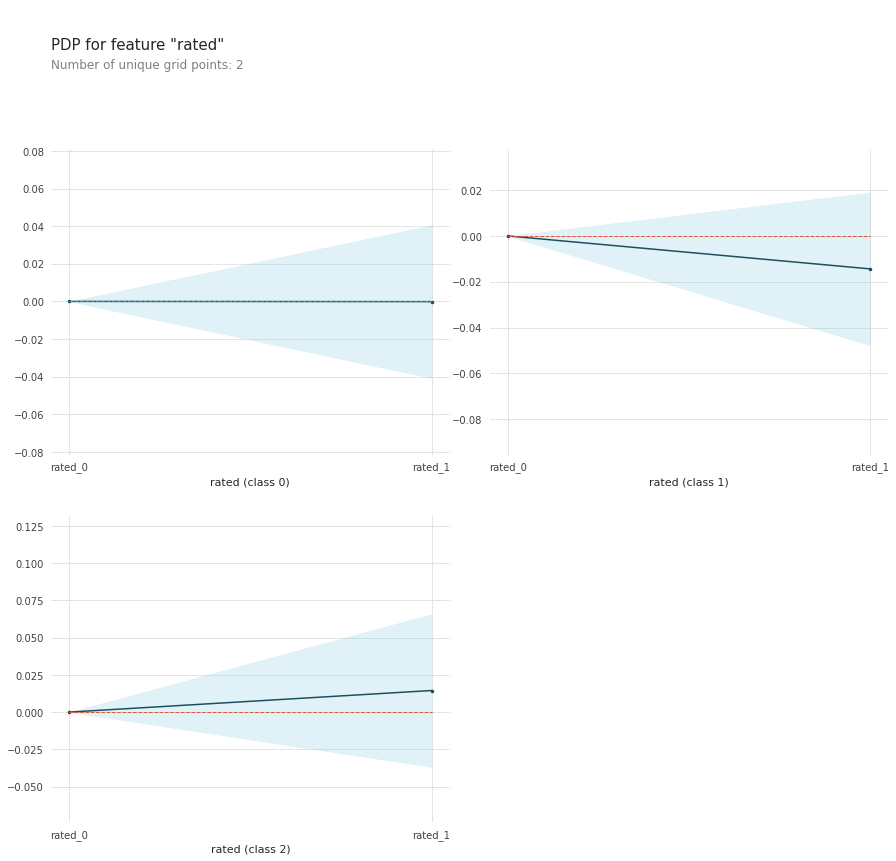

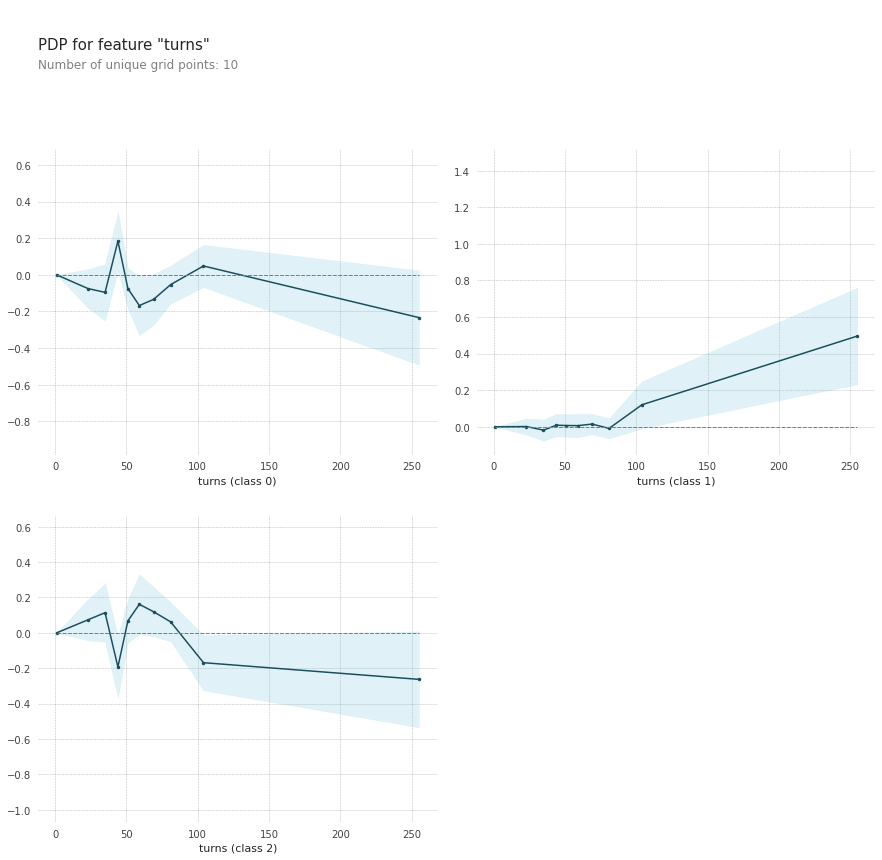

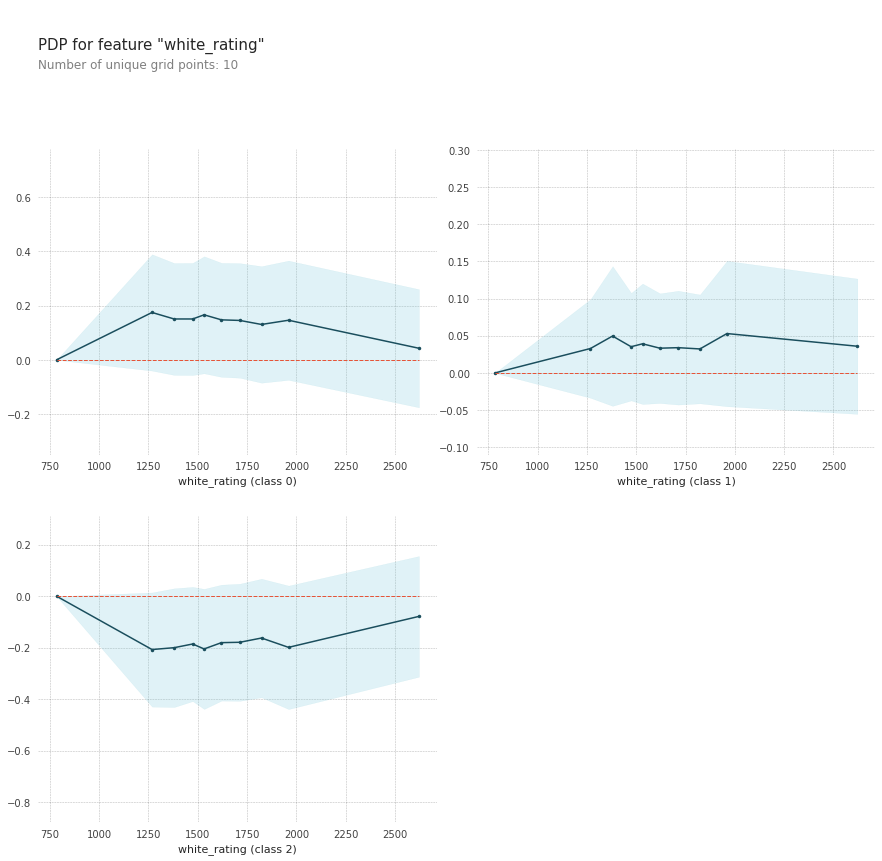

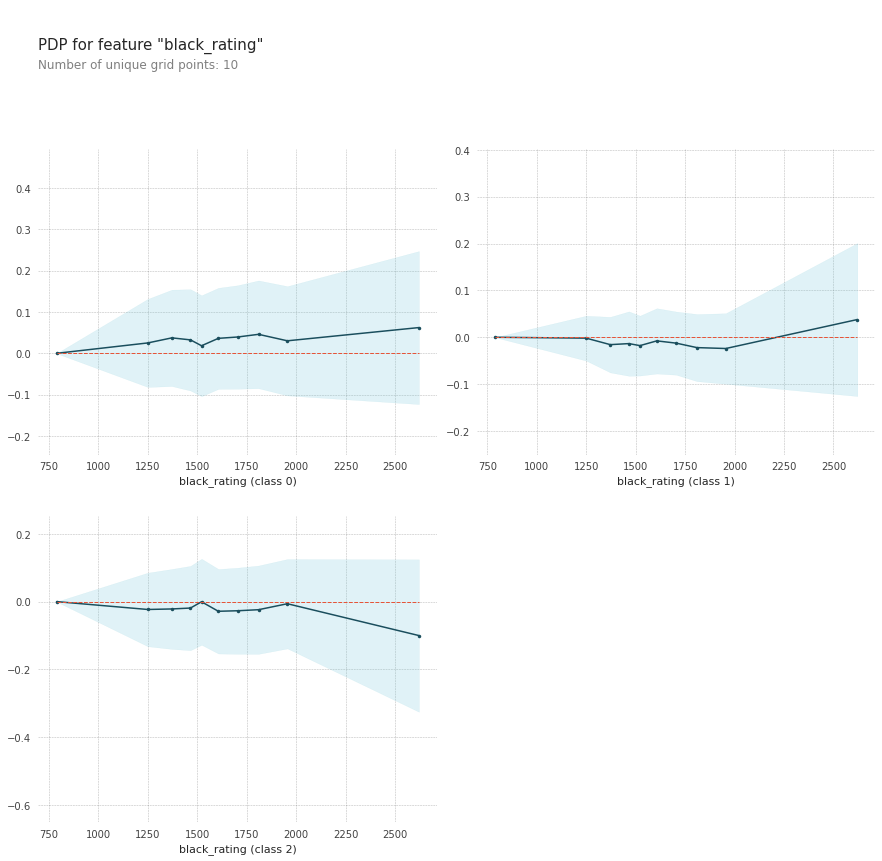

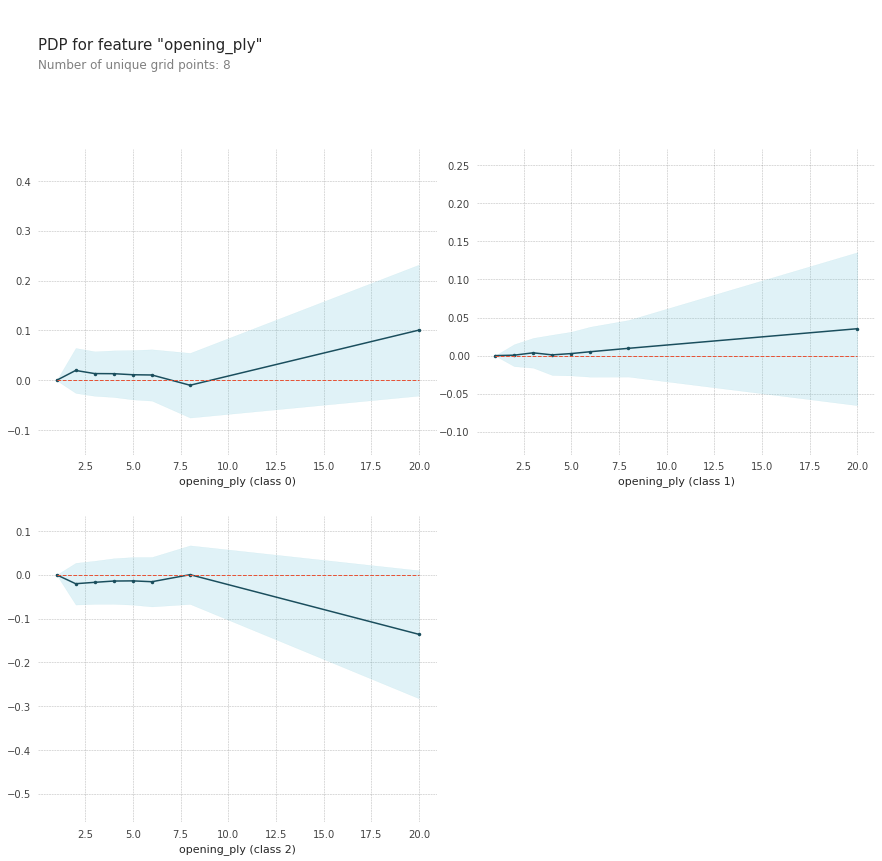

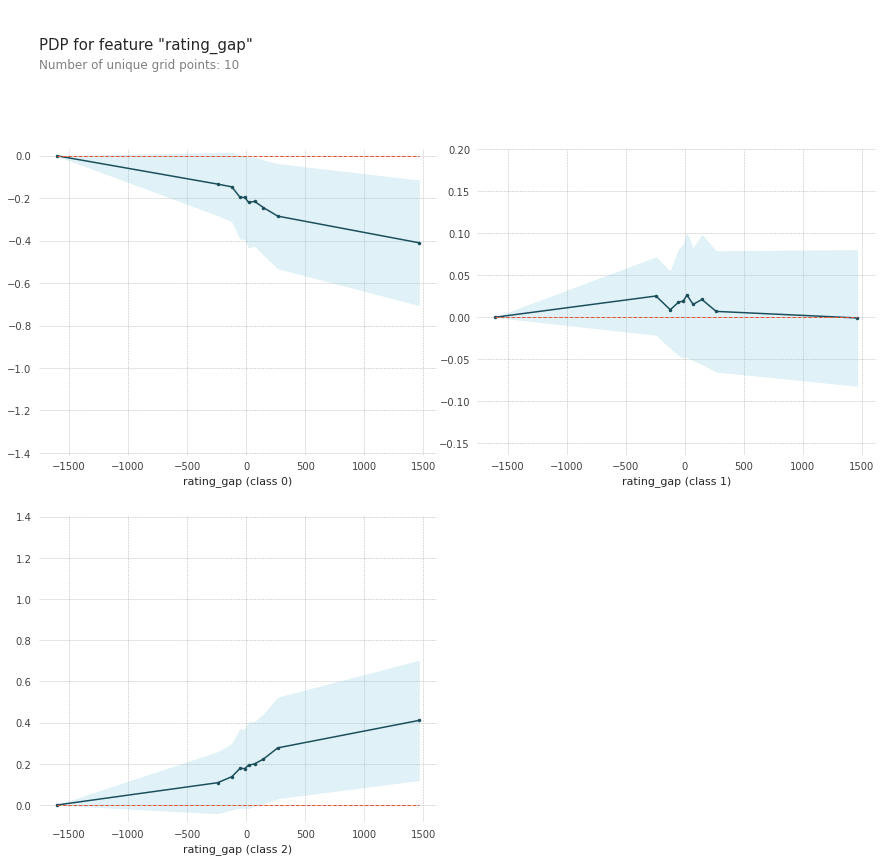

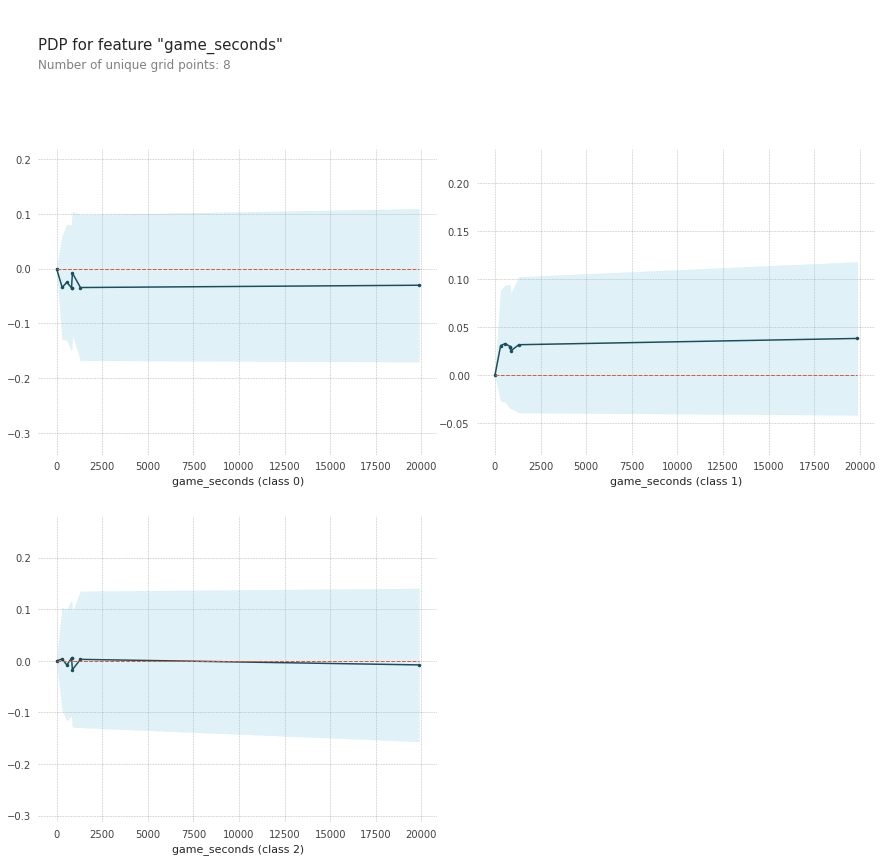

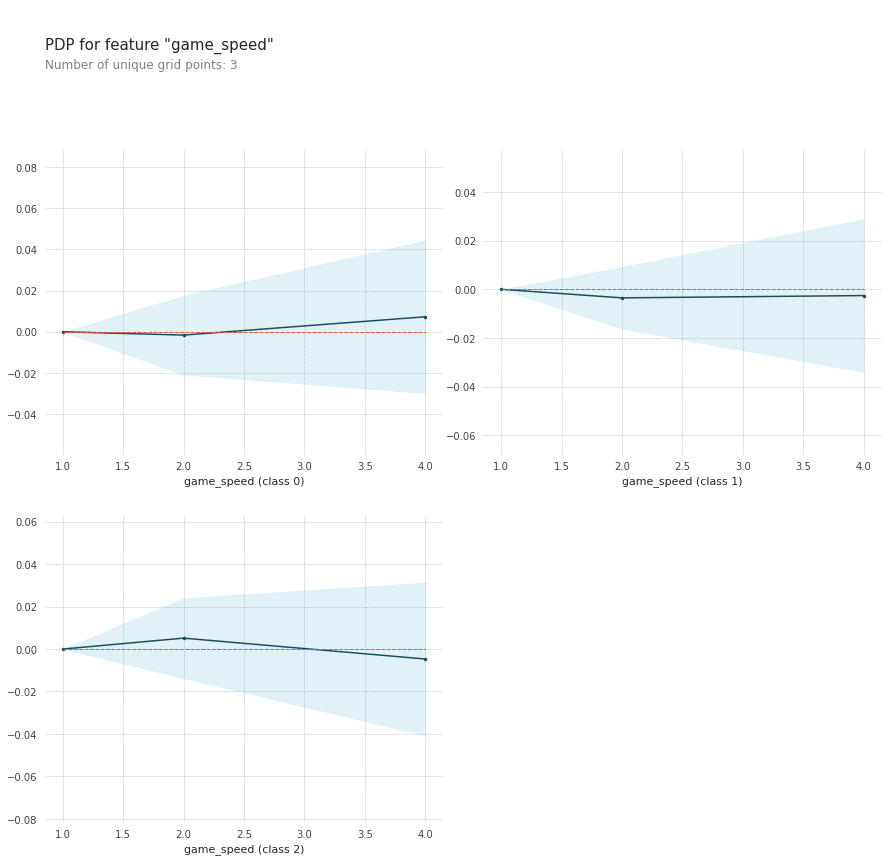

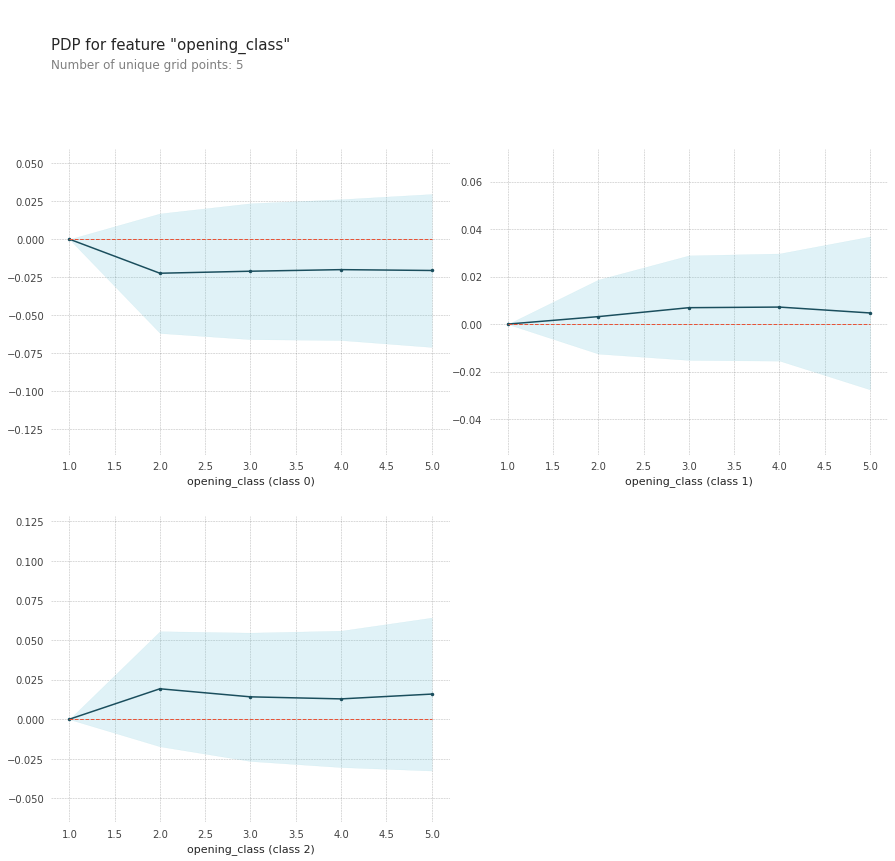

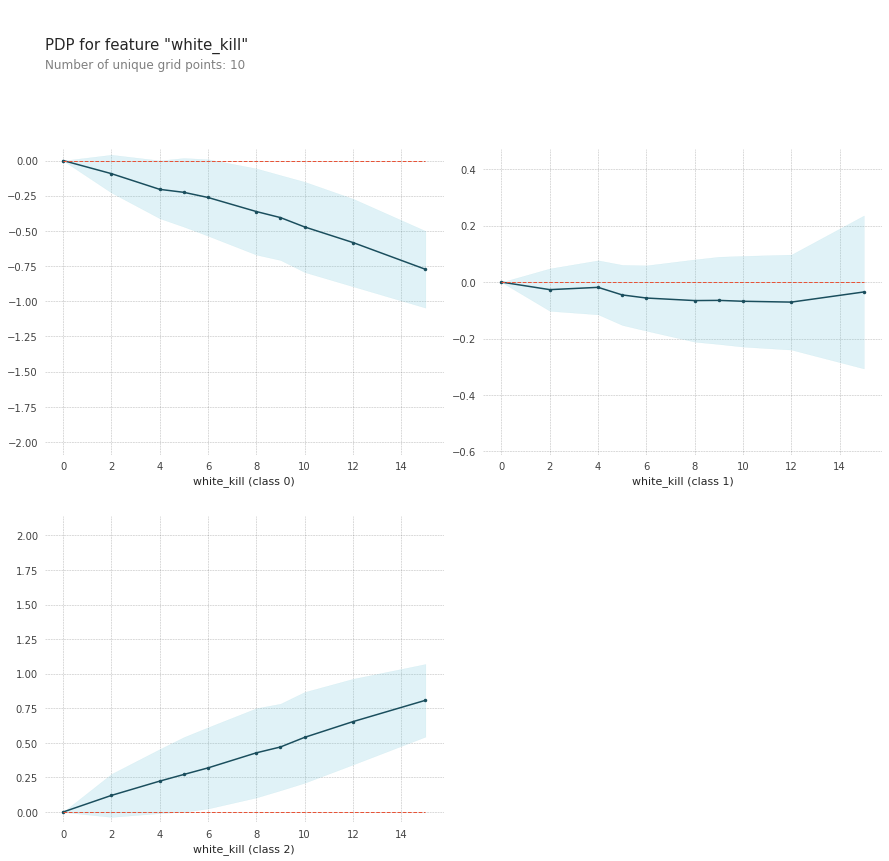

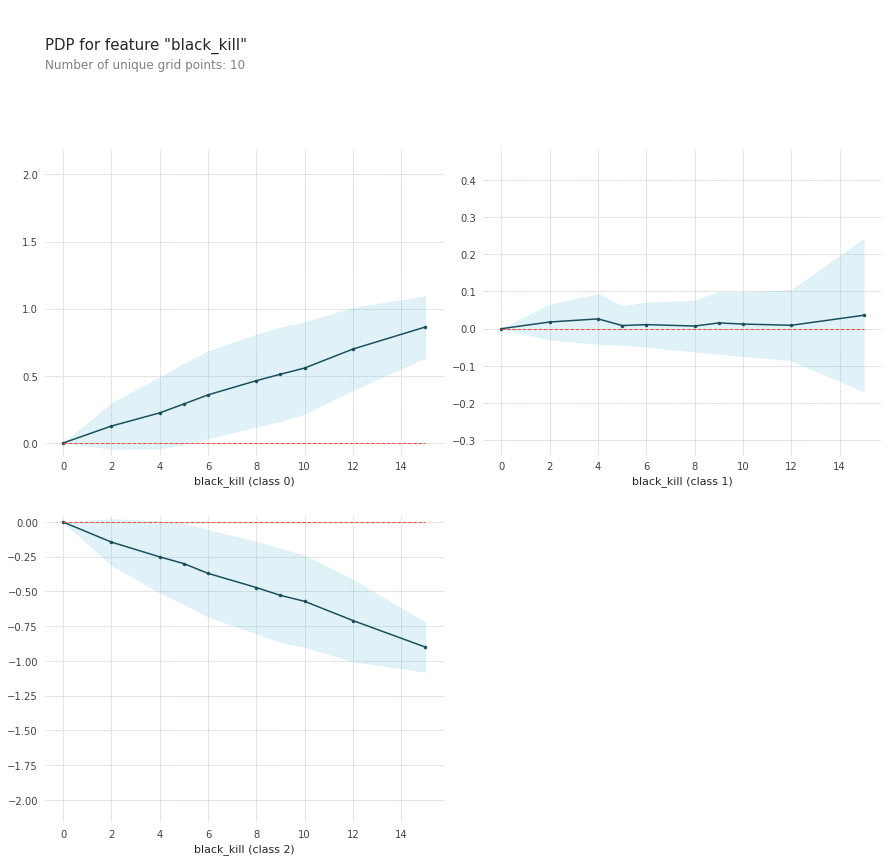

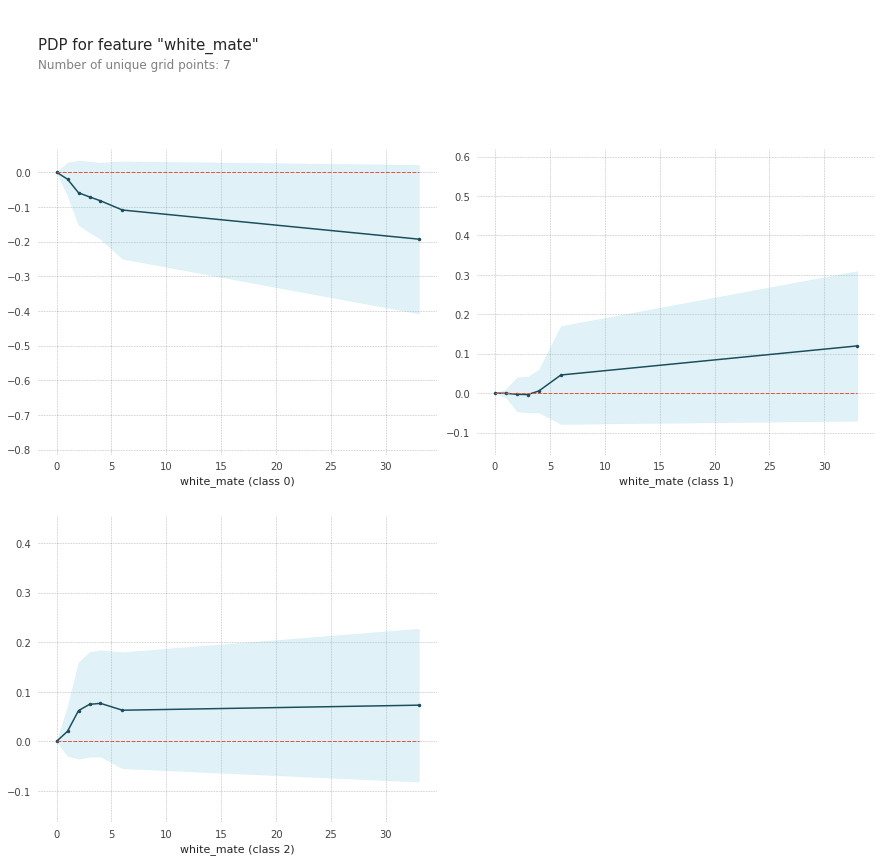

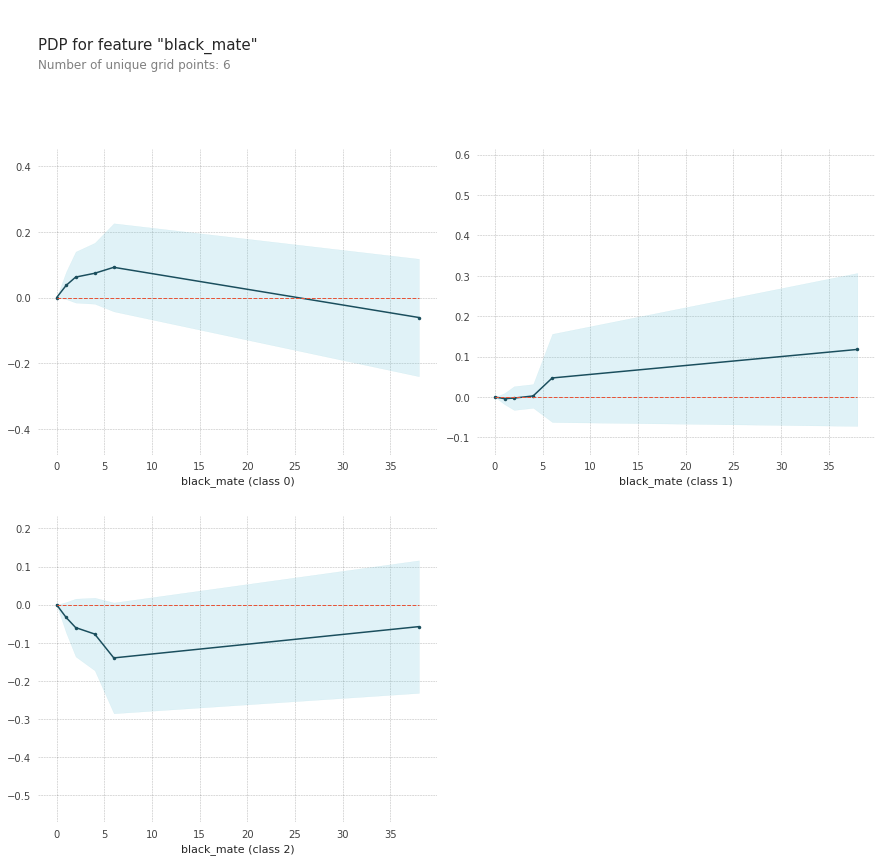

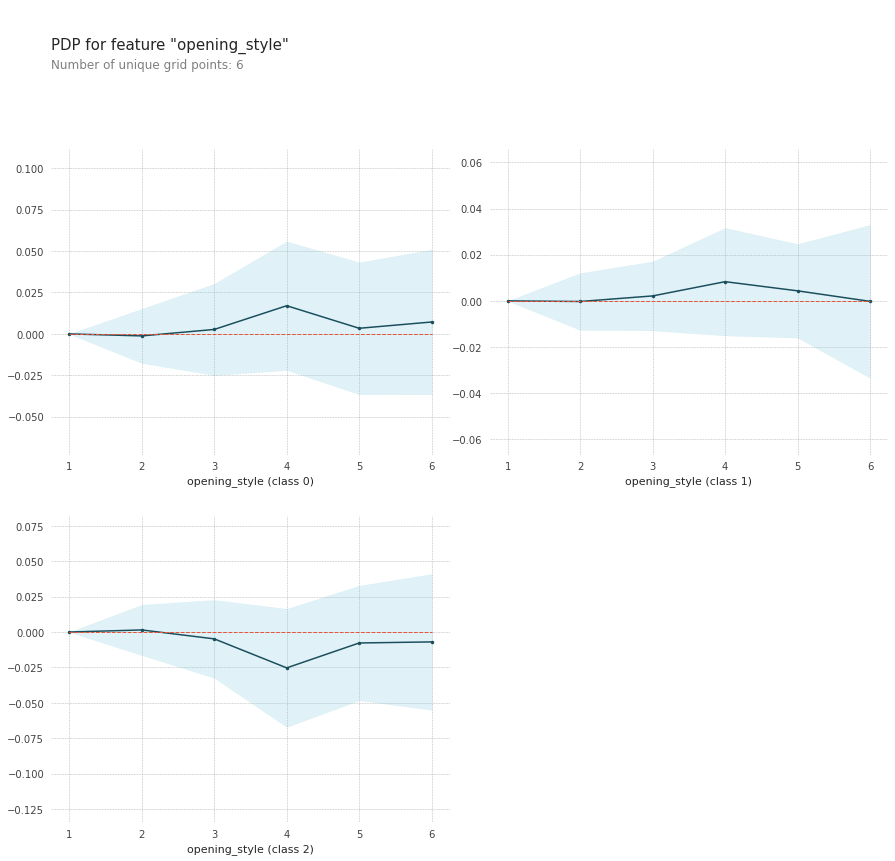

In [ ]:
for i in feature_names :

  isolated = pdp_isolate(
      model= model,
      dataset= X_test_processed_df,
      model_features= X_test.columns,
      feature=i
  )
  pdp_plot(isolated, feature_name=i);

In [ ]:
feature = 'opening_style'
for item in pipe_xgb_e.named_steps['preprocessing']['ordinalencoder'].mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

isolated = pdp_isolate(
      model= model,
      dataset= X_test_processed_df,
      model_features= X_test.columns,
      feature=feature
)

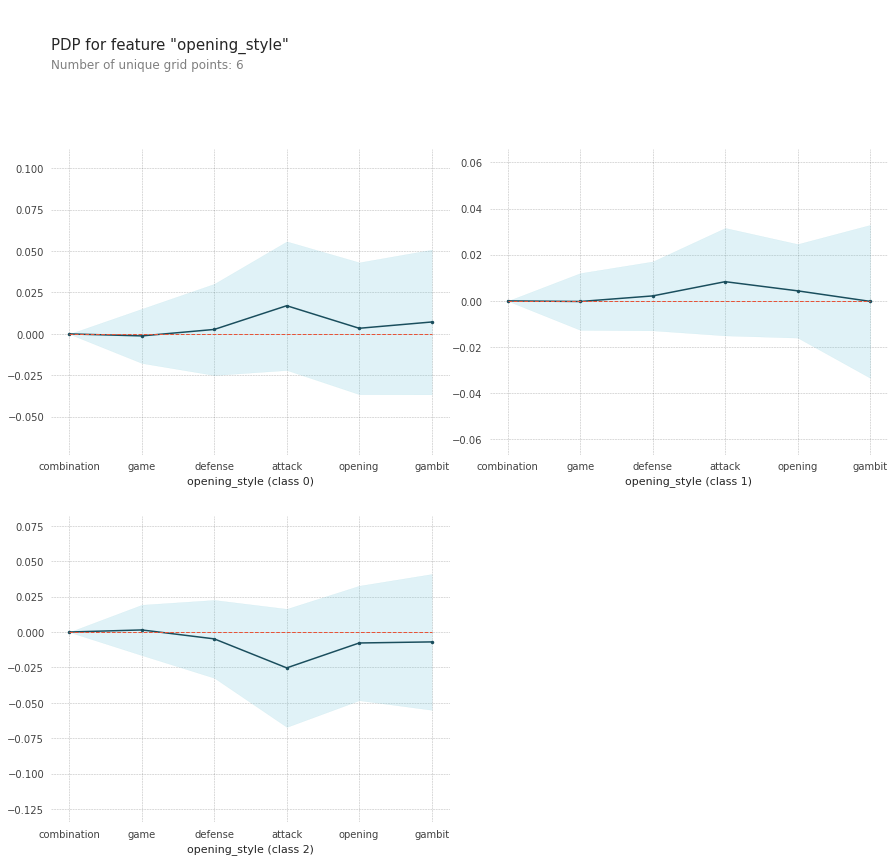

In [ ]:
fig, axes = pdp.pdp_plot(pdp_isolate_out=isolated, feature_name=feature, x_quantile=True)
axes['pdp_ax'][0].set_xticklabels(['combination', 'game', 'defense', 'attack', 'opening', 'gambit']);
axes['pdp_ax'][1].set_xticklabels(['combination', 'game', 'defense', 'attack', 'opening', 'gambit']);
axes['pdp_ax'][2].set_xticklabels(['combination', 'game', 'defense', 'attack', 'opening', 'gambit']);

In [ ]:
features = ['black_kill', 'white_kill']

interaction = pdp_interact(
    model=model, 
    dataset=X_test_processed_df,
    model_features=X_test.columns, 
    features=features
)

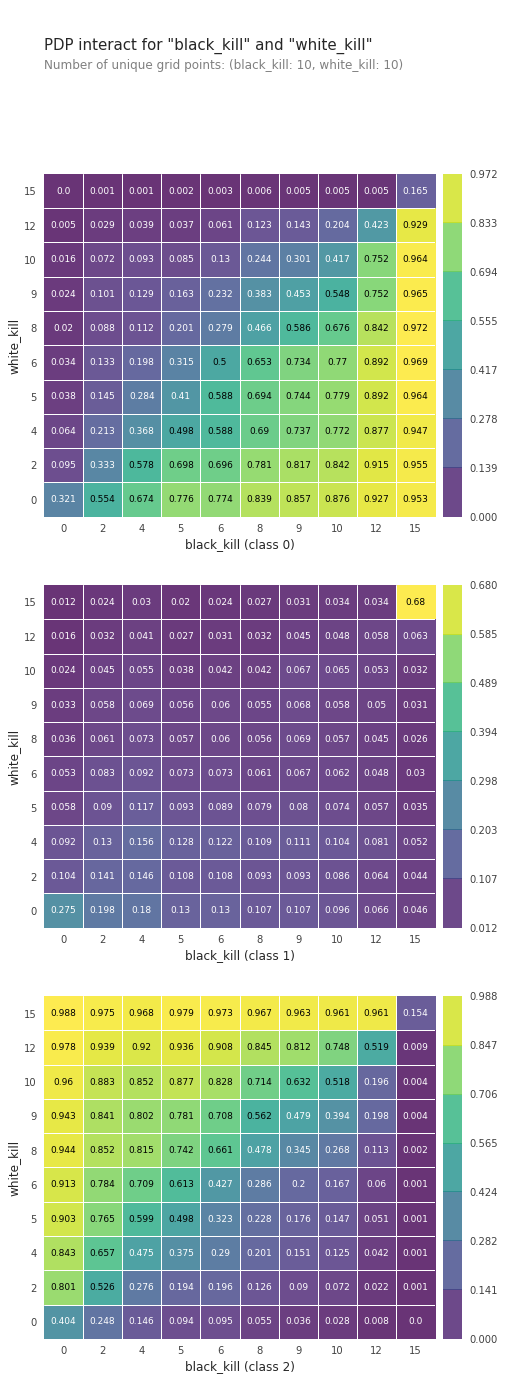

In [ ]:
fig, ax = pdp_interact_plot(pdp_interact_out=interaction, plot_type='grid', feature_names=features, ncols=1);

In [ ]:
features = ['black_mate', 'white_mate']

interaction = pdp_interact(
    model=model, 
    dataset=X_test_processed_df,
    model_features=X_test.columns, 
    features=features
)

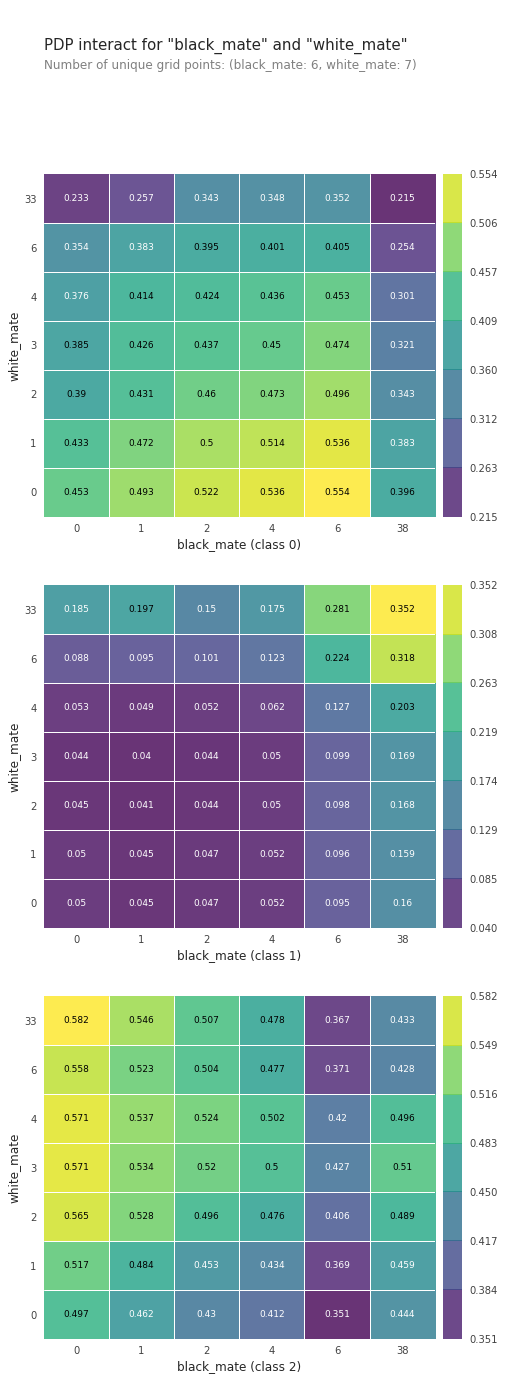

In [ ]:
fig, ax = pdp_interact_plot(interaction, plot_type='grid', feature_names=features, ncols=1);

In [ ]:
# shap

row = X_test.iloc[[0]]  
row

rated  turns  white_rating  ...  white_mate  black_mate  opening_style
3547   True    112          1679  ...           4           7    combination

[1 rows x 14 columns]

In [ ]:
explainer = shap.TreeExplainer(model)
row_processed = pipe_xgb_e.named_steps['preprocessing'].transform(row)
shap_values = explainer.shap_values(row_processed)

In [ ]:
shap.initjs()
for i in range(0,3):
    display(shap.force_plot(base_value=explainer.expected_value[i], shap_values=shap_values[i], features=row, link='logit'))

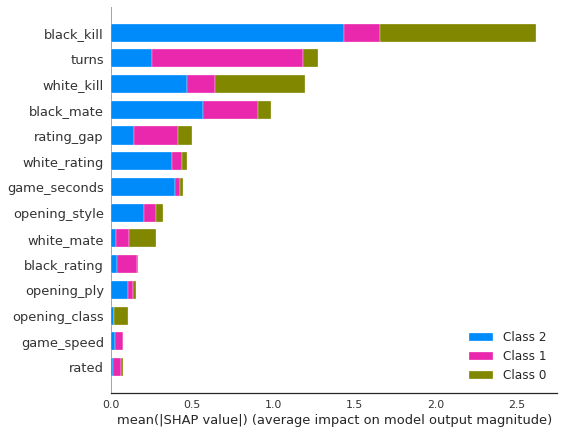

In [ ]:
shap.summary_plot(shap_values, X_test);

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_train_encoded.iloc[:100])
for i in range(0,3):
  display(shap.force_plot(explainer.expected_value[i], shap_values[i], X_test.iloc[:100]))

NameError: ignored

In [ ]:
df_f = pd.DataFrame({
    'pred_proba': zip(pred_proba_xgb_e), # 예측확률 
    'status_group': y_test # 실제값
})

df_concat = pd.concat([df_f, X_test], axis=1)
df_concat

pred_proba  ... opening_style
3547        ([0.7350682, 0.14169233, 0.12323947],)  ...   combination
11318      ([0.6984548, 0.118507504, 0.18303776],)  ...        attack
9085       ([0.7008614, 0.0024132028, 0.2967254],)  ...       defense
7053     ([0.014928894, 0.0047260537, 0.9803451],)  ...       defense
18995        ([0.71412, 0.27826947, 0.007610551],)  ...       defense
...                                            ...  ...           ...
4532   ([5.3744545e-05, 0.0016195396, 0.9983267],)  ...   combination
15112   ([0.94713914, 0.05259407, 0.00026677287],)  ...          game
12205    ([0.9368898, 0.0036502345, 0.059459906],)  ...       defense
13384     ([0.9483486, 0.011291976, 0.040359467],)  ...          game
5485       ([0.34419194, 0.02395209, 0.63185596],)  ...       defense

[3925 rows x 16 columns]

In [ ]:
df_concat_reset = df_concat.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)

white_max = [np.max(j) == j[2] for i in df_concat_reset.pred_proba for j in i]
black_max = [np.max(j) == j[0] for i in df_concat_reset.pred_proba for j in i]
draw_max =  [np.max(j) == j[1] for i in df_concat_reset.pred_proba for j in i]

white = df_concat_reset['status_group'] == 'white'
draw = df_concat_reset['status_group'] == 'draw'
black = df_concat_reset['status_group'] == 'black'
white_r = (white) == white_max
white_w = ~white_r
black_r = (black) == black_max
black_w = ~black_r
draw_r = (draw) == draw_max
draw_w = ~draw_r

In [ ]:
df_concat_reset[white & white_r].sample(n=5, random_state=1)

pred_proba  ... opening_style
258    ([0.043009467, 0.011325011, 0.9456655],)  ...       defense
294    ([0.036614984, 0.012202296, 0.9511827],)  ...       defense
1216  ([0.05311319, 0.0037221597, 0.94316465],)  ...        gambit
3888  ([0.0056049027, 0.018797489, 0.9755976],)  ...       defense
2023   ([0.051925607, 0.03696919, 0.91110516],)  ...       defense

[5 rows x 16 columns]

In [ ]:
df_concat_reset[black & black_r].sample(n=5, random_state=1)

pred_proba  ... opening_style
3267     ([0.9216882, 0.07429374, 0.004018034],)  ...   combination
3364     ([0.7274052, 0.022714984, 0.24987988],)  ...       defense
488       ([0.75825, 0.0007636728, 0.24098633],)  ...       defense
1085   ([0.95896095, 0.0045517134, 0.03648728],)  ...        attack
1171  ([0.9944537, 0.005356092, 0.00019022361],)  ...       defense

[5 rows x 16 columns]

In [ ]:
df_concat_reset[draw & draw_r].sample(n=5, random_state=1)

pred_proba  ... opening_style
3528   ([0.00582402, 0.99212414, 0.0020518624],)  ...       defense
2548  ([0.0006661863, 0.9977483, 0.0015855168],)  ...       defense
2688    ([0.030192243, 0.9391864, 0.030621395],)  ...        attack
2717   ([0.0036190555, 0.994395, 0.0019859553],)  ...          game
1970     ([0.00580237, 0.9898246, 0.004373022],)  ...          game

[5 rows x 16 columns]

In [ ]:
def explain(row_number):

    white_class = 'white'
    white_class_index = 2
    draw_class = 'draw'
    draw_class_index = 1
    black_class = 'black'
    black_class_index = 0

    # row 값을 변환
    row = X_test_reset.iloc[[row_number]]
    row_processed = pipe_xgb_e.named_steps['preprocessing'].transform(row)

    # 예측확률
    pred = model.predict(row_processed)[0]
    if pred == 'white' : 
      pred_proba = model.predict_proba(row_processed)[0, white_class_index]
    elif pred == 'draw' :
      pred_proba = model.predict_proba(row_processed)[0, draw_class_index]
    else : 
      pred_proba = model.predict_proba(row_processed)[0, black_class_index]
    pred_proba *= 100

    print(f'체스게임 승자에 대한 예측결과는 {pred} 으로, 확률은 {pred_proba:.0f}% 입니다.')
    
    # SHAP
    shap_values = explainer.shap_values(row_processed)

    # black에 대한 top 3 pros, cons
    feature_names = row.columns
    feature_values = row.values[0]

    if pred == 'black' :
      shaps = pd.Series(shap_values[0][0], zip(feature_names, feature_values))
    elif pred =='draw' :
      shaps = pd.Series(shap_values[1][0], zip(feature_names, feature_values))
    else : 
      shaps = pd.Series(shap_values[2][0], zip(feature_names, feature_values))

    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # 예측에 가장 영향을 준 top3
    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = pros 
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top1
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons 
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    for i in range(0,3):
      display(shap.force_plot(base_value=explainer.expected_value[i], shap_values=shap_values[i], features=row, link='logit'))


In [ ]:
explain(258)

체스게임 승자에 대한 예측결과는 white 으로, 확률은 95% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. white_kill : 12
2. turns : 81
3. white_mate : 9


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. black_kill : 10
2. rating_gap : -151
3. black_mate : 2


In [ ]:
explain(1171)

체스게임 승자에 대한 예측결과는 black 으로, 확률은 99% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. black_kill : 14
2. white_mate : 0
3. white_kill : 7


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. opening_class : semi_open_game
2. rating_gap : 61
3. black_rating : 1573


In [ ]:
explain(3528)

체스게임 승자에 대한 예측결과는 draw 으로, 확률은 99% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. turns : 189
2. white_kill : 15
3. white_mate : 19


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. black_rating : 1812
2. white_rating : 1500
3. opening_style : defense
